In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Any
import pandas as pd
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)




[*********************100%***********************]  1 of 1 completed


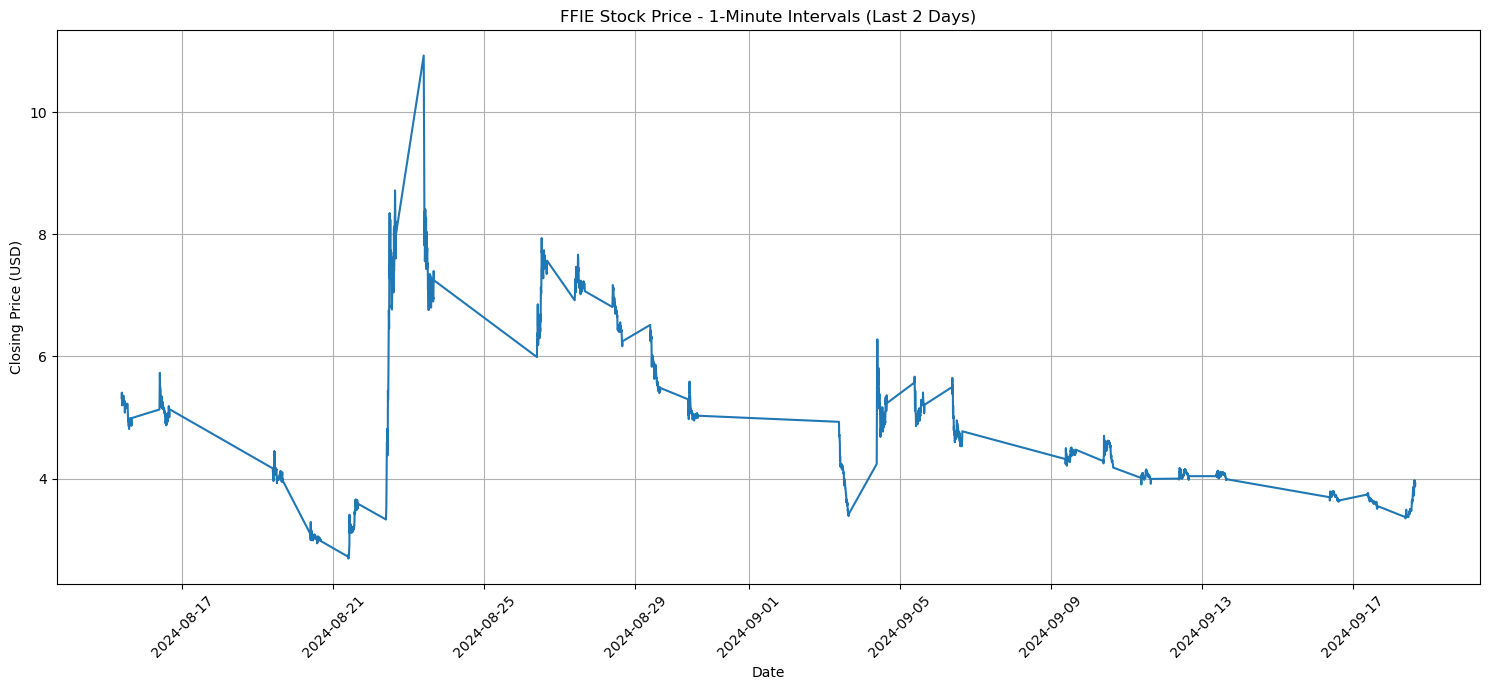

                            Open   High    Low  Close  Adj Close    Volume
Datetime                                                                  
2024-08-15 09:30:00-04:00  5.400  5.400  4.888  5.320      5.320  27312632
2024-08-15 09:35:00-04:00  5.292  5.472  5.240  5.408      5.408   6035451
2024-08-15 09:40:00-04:00  5.404  5.448  5.204  5.276      5.276   3097670
2024-08-15 09:45:00-04:00  5.268  5.420  5.200  5.200      5.200   3038653
2024-08-15 09:50:00-04:00  5.204  5.396  5.204  5.300      5.300   3246078


In [101]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define the ticker and date range
ticker = 'FFIE'
end_date = datetime.now()
start_date = end_date - timedelta(days=35)  # Max 7 days for 5-minute data

# Fetch the data
data = yf.download(ticker, start=start_date, end=end_date, interval='5m')

# Plot the closing prices
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['Close'])
plt.title(f'{ticker} Stock Price - 1-Minute Intervals (Last 2 Days)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the first few rows to see the data structure
print(data.head())

In [96]:


class XStrategyBacktest:
    def __init__(self, data: pd.DataFrame, start_date: datetime, end_date: datetime,
                 up_threshold: float = 0.8, down_threshold: float = 0.5):
        logger.info(f"Initializing XStrategyBacktest with start_date: {start_date}, end_date: {end_date}")
        self.start_date = start_date
        self.end_date = end_date
        self.data = data.loc[start_date.replace(hour=9, minute=30, second=0, microsecond=0):end_date.replace(hour=16, minute=0, second=0, microsecond=0)]
        self.position = 0
        self.base_price = self.data['Close'].iloc[0]
        self.entry_price = None
        self.trades = []
        self.pnl = 0
        self.pnls = []
        self.up_threshold = up_threshold
        self.down_threshold = down_threshold
        logger.info(f"Initialization complete. Base price: {self.base_price}")
    
    def on_tick(self, tick):
        current_price = tick['Close']
        logger.debug(f"Processing tick at {tick.name}. Current price: {current_price}")
        
        if self.position == 0:
            self.base_price = max(current_price, self.base_price)
            logger.debug(f"No position. Updated base price: {self.base_price}")
        
        if self.position > 0:
            self.base_price = min(current_price, self.base_price)
            logger.debug(f"Long position. Updated base price: {self.base_price}")
        
        if self.position > 0 and current_price > self.base_price + self.up_threshold:
            logger.info(f"Selling at {current_price}, base price is {self.base_price}, previous position is {self.position}")
            self.position = 0
            self.base_price = current_price
            self.trades.append({'type': 'sell', 'price': current_price, 'timestamp': tick.name})
            self.pnl += current_price - self.entry_price
            logger.info(f"Trade executed. New PNL: {self.pnl}")
            self.entry_price = None
        
        if self.position <= 0 and current_price < self.base_price - self.down_threshold:
            logger.info(f"Buying at {current_price}, base price is {self.base_price}, previous position is {self.position}")
            self.position = 1
            self.base_price = current_price
            self.trades.append({'type': 'buy', 'price': current_price, 'timestamp': tick.name})
            self.entry_price = current_price
    
    def run(self):
        logger.info("Starting backtest run")
        for _, row in self.data.iterrows():
            self.on_tick(row)
        logger.info(f"Backtest complete. Final PNL: {self.pnl}")
    
    def pnl_table(self):
        df = pd.DataFrame(self.trades)
        summary_table = df.set_index('type').loc['buy'].reset_index()\
            .merge(df.set_index('type').loc['sell'].reset_index(), 
                   left_index=True, right_index=True, suffixes=('_buy', '_sell'))        
        summary_table['return'] = summary_table['price_sell'] / summary_table['price_buy'] - 1
        summary_table['cum_return'] = (1+summary_table['return']).cumprod()
        return summary_table
    
    

In [106]:
backtest = XStrategyBacktest(data, data.index.min(), data.index.max(), up_threshold=0.2, down_threshold=0.7)
backtest.run()

INFO:root:Initializing XStrategyBacktest with start_date: 2024-08-15 09:30:00-04:00, end_date: 2024-09-18 15:55:00-04:00
INFO:root:Initialization complete. Base price: 5.320000171661377
INFO:root:Starting backtest run
INFO:root:Buying at 4.9120001792907715, base price is 5.73199987411499, previous position is 0
INFO:root:Trade executed. New PNL: 0
INFO:root:Selling at 5.188000202178955, base price is 4.871999740600586, previous position is 1
INFO:root:Trade executed. New PNL: 0.2760000228881836
INFO:root:Buying at 4.168099880218506, base price is 5.188000202178955, previous position is 0
INFO:root:Trade executed. New PNL: 0.2760000228881836
INFO:root:Selling at 4.304999828338623, base price is 3.9602999687194824, previous position is 1
INFO:root:Trade executed. New PNL: 0.4128999710083008
INFO:root:Buying at 3.0899999141693115, base price is 4.449999809265137, previous position is 0
INFO:root:Trade executed. New PNL: 0.4128999710083008
INFO:root:Selling at 3.2899999618530273, base pric

In [107]:
backtest.pnl_table()

,type_buy,price_buy,timestamp_buy,type_sell,price_sell,timestamp_sell,return,cum_return
0,buy,4.9120,2024-08-16 13:10:00-04:00,sell,5.1880,2024-08-16 15:25:00-04:00,0.056189,1.056189
1,buy,4.1681,2024-08-19 09:30:00-04:00,sell,4.3050,2024-08-19 10:20:00-04:00,0.032845,1.090879
2,buy,3.0900,2024-08-20 09:30:00-04:00,sell,3.2900,2024-08-20 09:40:00-04:00,0.064725,1.161486
3,buy,7.2800,2024-08-22 11:55:00-04:00,sell,7.8400,2024-08-22 12:10:00-04:00,0.076923,1.250831
4,buy,7.2600,2024-08-22 12:25:00-04:00,sell,7.7400,2024-08-22 12:30:00-04:00,0.066116,1.333531
5,buy,6.8000,2024-08-22 13:05:00-04:00,sell,7.0600,2024-08-22 13:30:00-04:00,0.038235,1.384519
6,buy,7.4000,2024-08-22 14:40:00-04:00,sell,7.6199,2024-08-22 14:45:00-04:00,0.029716,1.425661
7,buy,7.6050,2024-08-22 15:40:00-04:00,sell,8.0795,2024-08-22 15:45:00-04:00,0.062393,1.514613
8,buy,10.0200,2024-08-23 09:40:00-04:00,sell,8.3800,2024-08-23 10:05:00-04:00,-0.163673,1.266712
9,buy,7.5600,2024-08-23 10:15:00-04:00,sell,8.2300,2024-08-23 10:25:00-04:00,0.088624,1.378974
